# Install detectron2

In [ ]:
!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!git clone https://github.com/facebookresearch/detectron2.git
!python -m pip install -e detectron2

     |████████████████████████████████| 274 kB 14.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=a9d618b765c70dcde0a53451386c62eb41a6f2386ccca262925c84d3e255f2ad
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Cloning into 'detectron2'...
remote: Enumerating objects: 13902, done.
remote: Total 13902 (delta 0), reused 0 (delta 0), pack-reused 13902
Receiving objects: 100% (13902/13902), 5.70 MiB | 16.73 MiB/s, done.
Resolving deltas: 100% (10054/10054), done.
Obtaining file:///content/detectron2
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 74 kB 4.3 MB/s 
     |████████████████████████████████| 145 kB 75.8 MB/s 
     |████████████████████████████████| 1

# After installation, you need to "restart kernel".

In [ ]:
import os
os._exit(00)

# Start running from the below cell (skip the above cell)

In [ ]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
#assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.10.0+cu111 True


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Choose the right folder based on classes/regimes

In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/detectron2/detectron/dataset/1536x/iii")

In [ ]:
#os.getcwd()
os.listdir(os.getcwd())

['label',
 'im_train',
 'im_val',
 'output_1_0_III_1500x',
 'df_pedicted_masks_distance.pickle',
 'mask_polygons_images_semicoln.csv',
 'mask_polygons_images.csv']

## Import and Register Custom Detectron2 Data

In [ ]:
import json
from detectron2.data.datasets import register_coco_instances

register_coco_instances("train", {}, "./label/train.json", "./im_train")
register_coco_instances("val", {}, "./label/val.json", "./im_val")

In [ ]:
MetadataCatalog.get("train")

Metadata(evaluator_type='coco', image_root='./im_train', json_file='./label/train.json', name='train')

In [ ]:
MetadataCatalog.get("val")

Metadata(evaluator_type='coco', image_root='./im_val', json_file='./label/val.json', name='val')

## Visualize training data

[02/14 07:52:33 d2.data.datasets.coco]: Loaded 9 images in COCO format from ./label/train.json


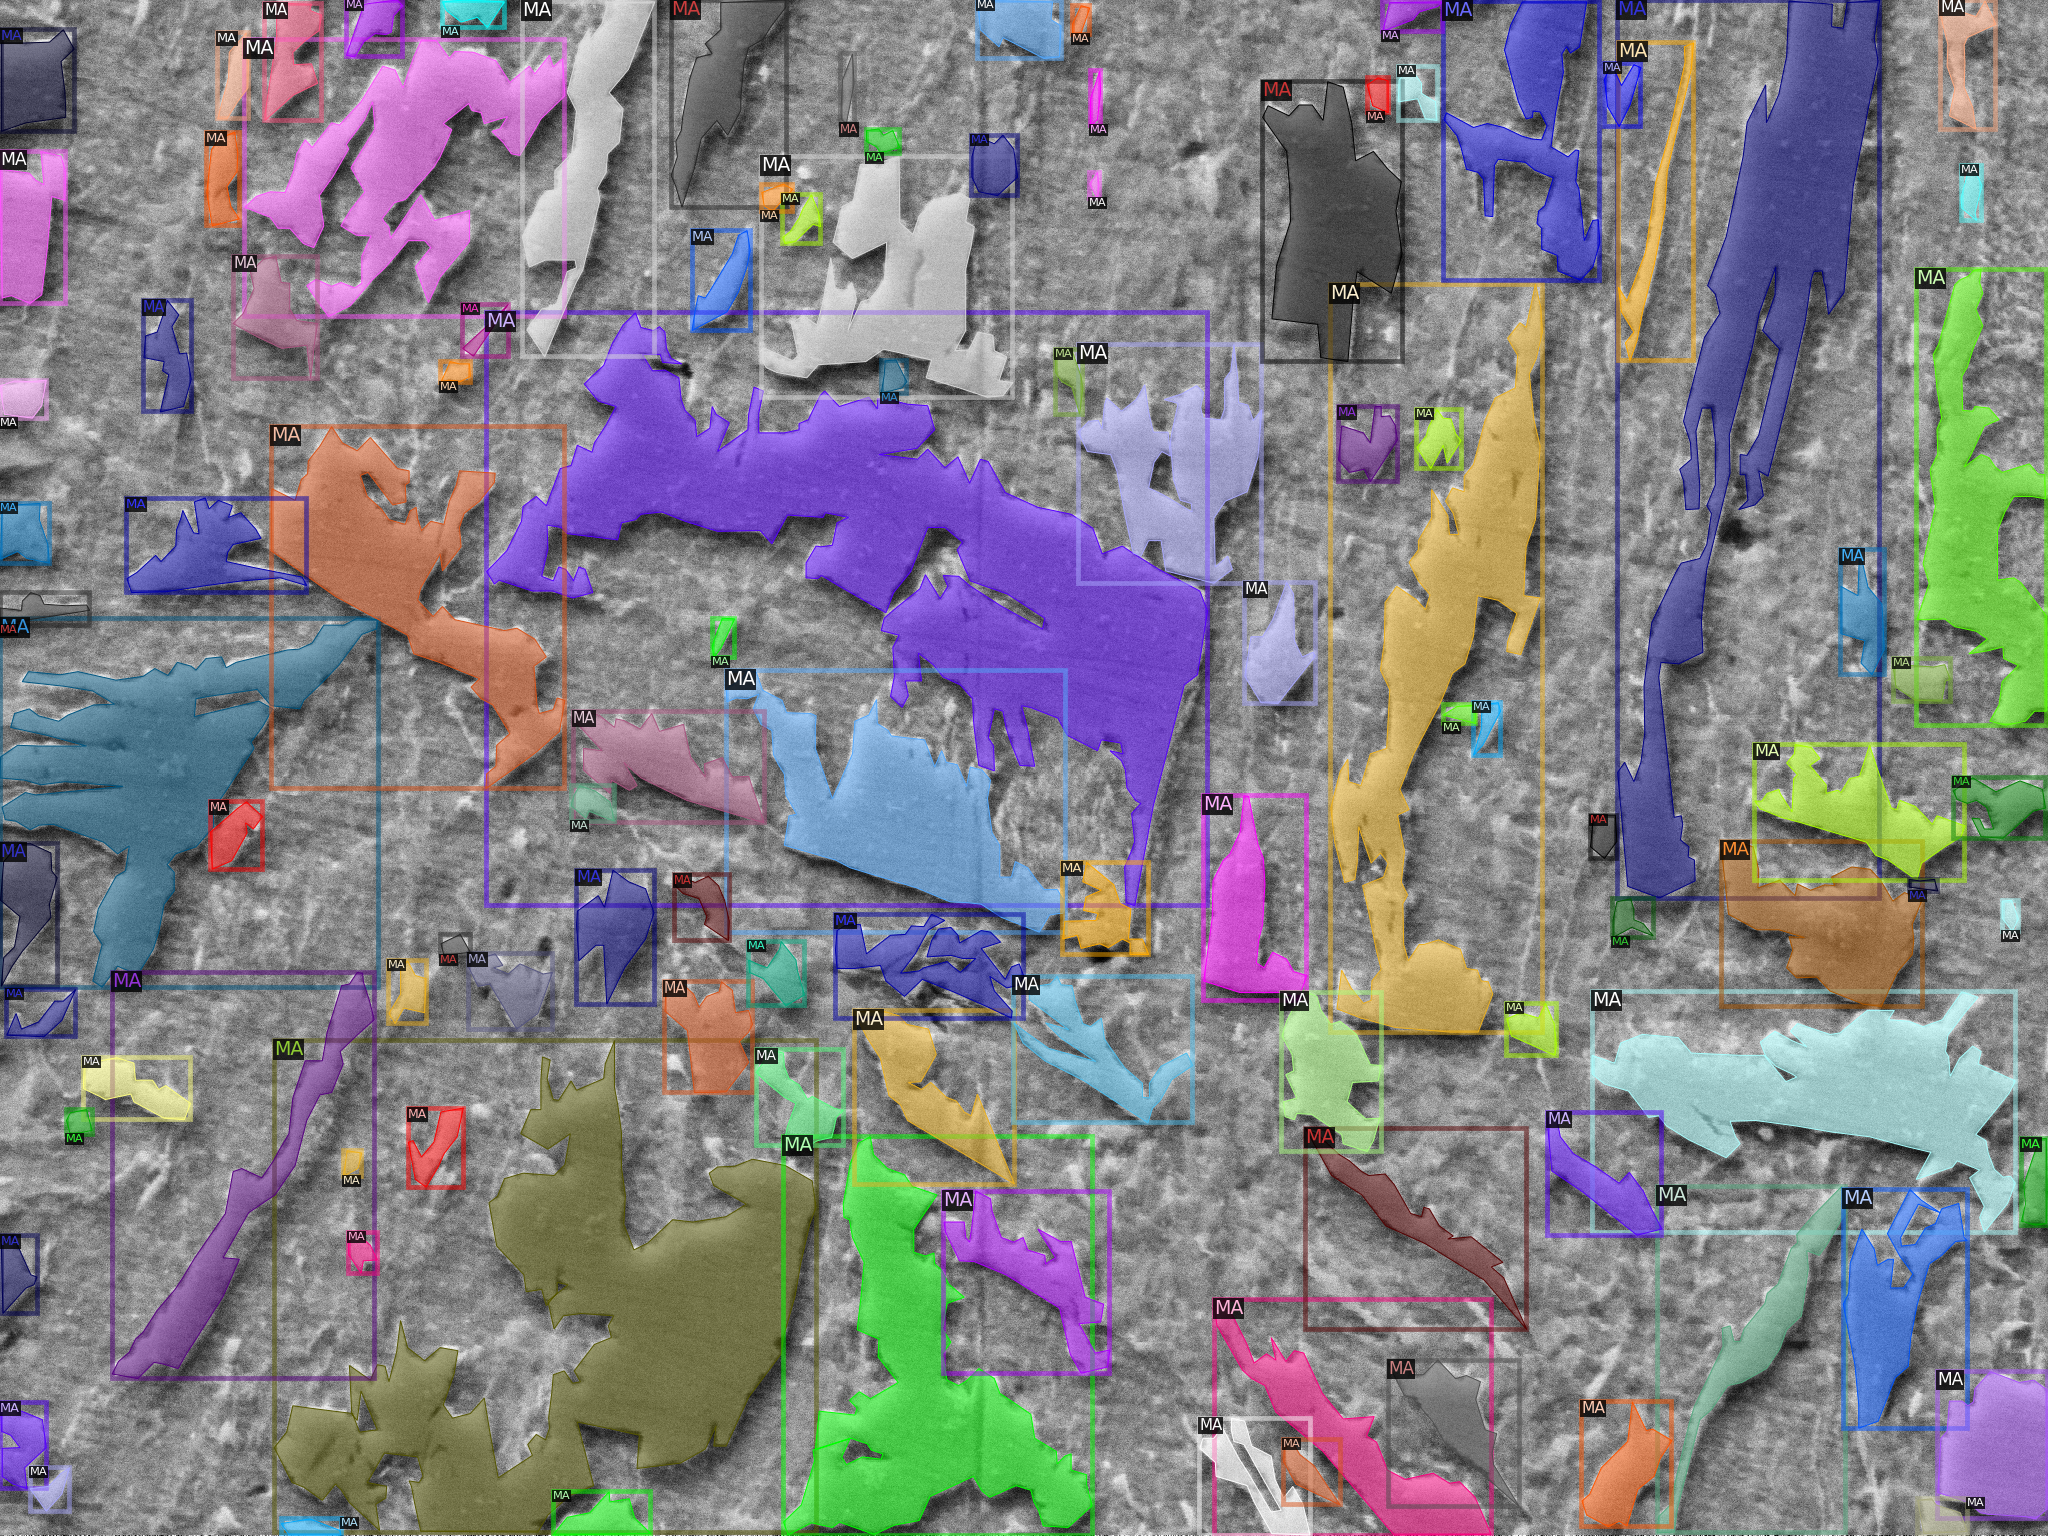

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

train_metadata = MetadataCatalog.get("train")
dataset_dicts = DatasetCatalog.get("train")

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])




In [ ]:
from detectron2.utils.visualizer import ColorMode,Visualizer

train_metadata = MetadataCatalog.get("val")
dataset_dicts = DatasetCatalog.get("val")


for d in dataset_dicts: 
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1.0)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])
    cv2.imwrite(d["file_name"], vis.get_image()[:, :, ::-1])
    #out = v.draw_instance_predictions(outputs["instances"].to("cpu"))



# Train Custom Detectron2 Detector

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [ ]:
# We are importing our own Trainer Module here to use the COCO validation evaluation during training.
# Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    return COCOEvaluator(dataset_name, cfg, True, output_folder)

  def build_hooks(self):
    hooks = super().build_hooks()
    hooks.insert(-1,LossEvalHook(
        self.cfg.TEST.EVAL_PERIOD,
        self.model,
        build_detection_test_loader(
            self.cfg,
            self.cfg.DATASETS.TEST[0],
            DatasetMapper(self.cfg,True)
        )
    ))
    return hooks

In [ ]:
# remove the existing config folders, else the training files will append to the existing ones
import shutil
shutil.rmtree("./output")

In [ ]:
import torch
import logging
torch.cuda.empty_cache()

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("val",)
# cfg.INPUT.MIN_SIZE_TRAIN = (800,)
# cfg.INPUT.MIN_SIZE_TEST = (800,)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.BASE_LR = 0.0005 # 0.0005 # pick a good LR
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.STEPS = []
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.TEST.EVAL_PERIOD = 20
# Maximum number of detections to return per image during inference (default 100 is based on the limit established for the COCO dataset)
# cfg.TEST.DETECTIONS_PER_IMAGE = 1500 # controls the maximum number of objects to be detected. Set it to a larger number if test images may contain >100 objects.
cfg.SOLVER.MAX_ITER = 50 #adjust up if val mAP is still rising, adjust down if overfit
cfg.OUTPUT_DIR = "./output_test/"

# train model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

## Move the contents from ./output_test/ to new folders with class/regime names for further analysis

Use this folder below for loading json. eg: ./output_2_14_iii_512_1500x/

In [ ]:
import json
import matplotlib.pyplot as plt

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr('./output_2_14_iii_512_1500x/metrics.json')
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.title('original data')
plt.xlim(0,1550)
plt.grid(axis='y', color='0.95')
plt.show()

In [ ]:
  experiment_metrics = [v for i, v in enumerate(load_json_arr('./output_2_14_iii_512_1500x/metrics.json')) if i % 2 == 0]

  loss = [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x]
  iterations = [x['iteration'] for x in experiment_metrics]
  
  df_loss = dict(zip(iterations, loss))
  min_loss_iter = list(df_loss.keys())[list(df_loss.values()).index(min(loss))]
  min_loss_value = list(df_loss.values())[list(df_loss.values()).index(min(loss))]
  
  final_loss_iter = list(df_loss)[-1]
  final_loss_value = list(df_loss.values())[-1]

  test_number = 20
  test_loss_value = list(df_loss.values())[test_number]
  test_loss_iteration = list(df_loss.keys())[test_number]

  print(f'iteration (minimum loss): {min_loss_iter} \n \
    value (minimum loss): {min_loss_value} \n \
    iteration (final loss): {final_loss_iter} \n \
    value (final loss): {final_loss_value} \n \
    iteration (test loss): {test_loss_iteration} \n \
    value (test loss): {test_loss_value}')